In [1]:
# import necessary tools
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from yellowbrick.text import TSNEVisualizer

In [2]:
# load data into DataFrame
comments = pd.read_csv('attack_annotated_comments.tsv', sep='\t', index_col=0)
annotations = pd.read_csv('attack_annotations.tsv', sep='\t')

In [3]:
# print the # of unique rev_id
print('There are', len(annotations['rev_id'].unique()), 'unique rev_id')

There are 115864 unique rev_id


In [4]:
# labels a comment as an attack if the majority of annotators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.5

In [5]:
# insert labels in comments
comments['attack'] = labels

In [6]:
# Parsing: remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [7]:
print('This is your DataFrame:\n')
print(comments.head())

This is your DataFrame:

                                                  comment  year  logged_in  \
rev_id                                                                       
37675   `- This is not ``creative``.  Those are the di...  2002      False   
44816   `  :: the term ``standard model`` is itself le...  2002      False   
49851     True or false, the situation as of March 200...  2002      False   
89320    Next, maybe you could work on being less cond...  2002       True   
93890                This page will need disambiguation.   2002       True   

             ns  sample  split  attack  
rev_id                                  
37675   article  random  train   False  
44816   article  random  train   False  
49851   article  random  train   False  
89320   article  random    dev   False  
93890   article  random  train   False  


In [8]:
print('These are the head of the comments classified as an attack\n')
print(comments.query('attack')['comment'].head())

These are the head of the comments classified as an attack

rev_id
801279             Iraq is not good  ===  ===  USA is bad   
2702703      ____ fuck off you little asshole. If you wan...
4632658         i have a dick, its bigger than yours! hahaha
6545332      == renault ==  you sad little bpy for drivin...
6545351      == renault ==  you sad little bo for driving...
Name: comment, dtype: object


In [9]:
# create X (comments), y (which is the outcome label the model has to learn)
X = comments['comment']
y = comments['attack']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

In [11]:
# instantiating the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.20, ngram_range=(1, 5),
                             max_features=100000, stop_words='english', use_idf=True)

In [12]:
# Transformation
count_train = vectorizer.fit_transform(X_train.values)
count_test = vectorizer.transform(X_test.values)

In [13]:
# Classifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15, 4), random_state=1)
clf.fit(count_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(15, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [14]:
# we save the predicted labels in variable pred to test the accuracy
pred = clf.predict(count_test)

In [15]:
# testing accuracy
print(metrics.accuracy_score(y_test, pred))

0.939193430275


In [16]:
# further evaluation of our model with confusion matrix which shows correct/incorrect labels
print(metrics.confusion_matrix(y_test, pred, labels=[False, True]))
print(metrics.classification_report(y_test, pred))

[[32584  1087]
 [ 1238  3327]]
             precision    recall  f1-score   support

      False       0.96      0.97      0.97     33671
       True       0.75      0.73      0.74      4565

avg / total       0.94      0.94      0.94     38236



# VISUAL DISTRIBUTION

In [17]:
from yellowbrick.text.freqdist import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [18]:
fig1 = plt.figure(figsize=(9, 8), dpi=80, facecolor='w', edgecolor='k')

In [19]:
vectorizer1 = CountVectorizer(stop_words='english')
docs1 = vectorizer1.fit_transform(X_train)
features1 = vectorizer1.get_feature_names()

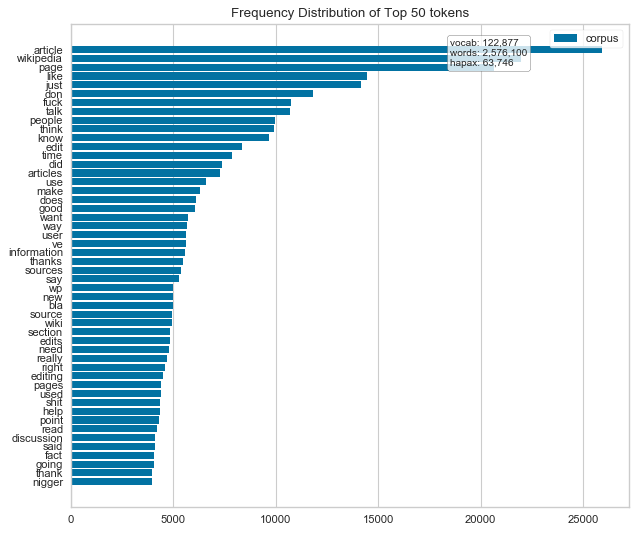

In [20]:
visualizer1 = FreqDistVisualizer(features=features1)
visualizer1.fit(docs1)
visualizer1.poof()